# Test LeNet on CIFAR
* CIFAR : 50 000 training images and 10 000 validation images
* After testing : 2 issues (low accuracy and overfitting) => we'll fine tune the LeNet model for this case
* * training process too slow : we increase the lr. positive effect but we are still overfitting
* *  overfitting : add convolutional layers (a very common architecture is one where each ouptut doubles the depth of the preceding layer) and decrease kernel size

After all this, there is improvement but we still have overfitting : 
* this will be solved by data augmentation
* to do so we add a new step in transform.compose (but only for the training data)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import requests
from functools import reduce

# this time, each image is rgb and 32*32. My inputs will be N*3*32*32 where N is batch size
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, scale=(0.8, 1.2), shear=10 ),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



training_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train) # it seems that random transformations are different from one epoch to the other, which is good ! 
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size=100, shuffle=True) 
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() #3*28*28
    image = image.transpose(1,2,0) #28*28*3 
    image = image * np.array([0.5])+ np.array([0.5]) #reverse normalisation
    image.clip(0,1) #ensures range is between 0 and 1
    return image
def img_transform(img):
    img = Image.open(img)
    img = transform(img) # apply the transform defined on top
    return img

In [3]:
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

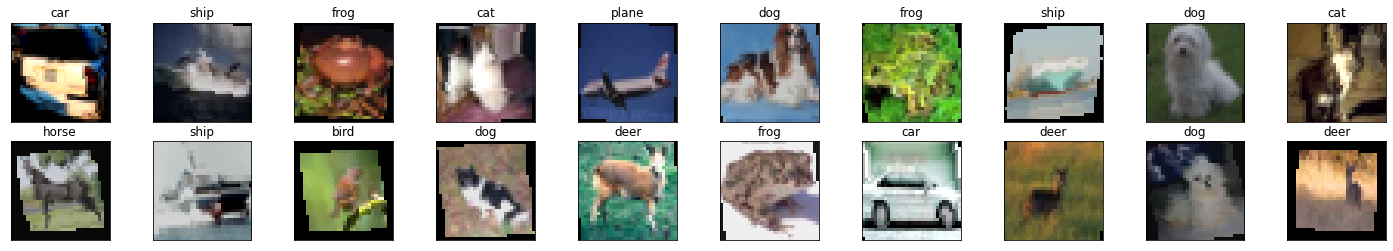

In [4]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks= [])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [5]:
print(torch.backends.cudnn.enabled, torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True True


In [6]:
# 1 padding de 1 ajoute un pixel à chaque bord
def image_size_after_convolution_and_pooling(initial_image_size, kernel_size, pool_stride, padding=0):
    return np.ceil((initial_image_size-(kernel_size-1-2*padding))/pool_stride)
def image_size_after_several_convolutions_and_poolings(initial_image_size, kernel_size, pool_stride, padding=0, nb_operations=1):
    return reduce(lambda x, _:image_size_after_convolution_and_pooling(x, kernel_size, pool_stride, padding),range(nb_operations), initial_image_size)


In [7]:
# we'll have to make some small changes
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        

        # convolution layers
        in_channels1 = 3 # 3 channel per input (rgb image)
        out_channels1 = in_channels2 = 16  
        out_channels2 = in_channels3 = 32 # doubled + adding layer 
        out_channels3 = 64 

        kernel_size = 3 #decrease kernel size is also a way to avoid overfitting 
        stride = 1 
        self.conv1 = nn.Conv2d(in_channels=in_channels1, out_channels=out_channels1, kernel_size=kernel_size, stride=stride, padding=1)
        self.conv2 = nn.Conv2d(in_channels=in_channels2, out_channels=out_channels2, kernel_size=kernel_size, stride=stride, padding=1)
        self.conv3 = nn.Conv2d(in_channels=in_channels3, out_channels=out_channels3, kernel_size=kernel_size, stride=stride, padding=1)

        # fully connected layers
        image_size = 32
        pool_stride = 2
        in_fc1 = int(image_size_after_several_convolutions_and_poolings(image_size, kernel_size, pool_stride, 1,3)**2*out_channels3)
        out_fc1 = in_fc2 = 500
        self.fc1 = nn.Linear(in_features=in_fc1, out_features=out_fc1)

        #ajout du dropout entre les fully connected layers
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(in_fc2,10) #classification

        
    def forward(self, x, dropout=False):
        pool_stride = 2
        pool_size = 2
        c1 = nn.functional.relu(self.conv1(x))
        p1 = nn.functional.max_pool2d(c1, kernel_size=pool_size, stride=pool_stride)
        c2 = nn.functional.relu(self.conv2(p1))
        p2 = nn.functional.max_pool2d(c2, kernel_size=pool_size, stride=pool_stride)

        c3 = nn.functional.relu(self.conv3(p2))
        p3 = nn.functional.max_pool2d(c3, kernel_size=pool_size, stride=pool_stride)

        flattened = p3.view(-1,4*4*64) # -1 here so that number of columns is maintained

        h = nn.functional.relu(self.fc1(flattened))

        if dropout: 
            h = self.dropout1(h) #not done in the video but you should disable dropout on test data

        score = self.fc2(h) #raw score here
        return score

In [8]:
LeNet()

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [9]:
model = LeNet().to(device) # model is on gpu
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr =0.001) # we increase the lr because training process is very slow => from 0.0001 tp 0.001
epochs = 50

running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for i in range(epochs):

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader: #les inputs sont de dimension 100 * 3* 32 * 32 (100 mesures, 3 channels, 32*32 pixels)

        inputs = inputs.to(device) # use gpu
        labels = labels.to(device)

       
        outputs = model.forward(inputs, dropout=True) 
        loss = criterion(outputs, labels) # see docs, it is normal, input is raw score and labels is class number of target
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs,1) #preds is the index of the max value for the 100 images

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels)
    else:
    #runs after for loop ends
        with torch.no_grad():
        # no need to compute derivative on validation set so we save memory
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model.forward(val_inputs, dropout=False)
                val_loss = criterion(val_outputs, val_labels)
                _, val_preds = torch.max(val_outputs,1) #preds is the index of the max value for the 100 images
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels)



    epoch_loss = running_loss/len(training_loader) #better method in 08_cnn_code
    epoch_acc = running_corrects/len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    print("training loss: {:4f}, accuracy : {:4f}".format(epoch_loss, epoch_acc.item()))

    val_epoch_loss = val_running_loss/len(validation_loader) 
    val_epoch_acc = val_running_corrects/len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print("validation loss: {:4f}, accuracy : {:4f}".format(val_epoch_loss, val_epoch_acc.item()))

training loss: 0.016853, accuracy : 0.384220
validation loss: 0.013700, accuracy : 0.499000
training loss: 0.013766, accuracy : 0.503640
validation loss: 0.011752, accuracy : 0.572200
training loss: 0.012409, accuracy : 0.555300
validation loss: 0.010610, accuracy : 0.623000
training loss: 0.011569, accuracy : 0.589200
validation loss: 0.010065, accuracy : 0.645300
training loss: 0.011047, accuracy : 0.610380
validation loss: 0.009407, accuracy : 0.666700
training loss: 0.010535, accuracy : 0.627620
validation loss: 0.009207, accuracy : 0.678100
training loss: 0.010185, accuracy : 0.640260
validation loss: 0.009241, accuracy : 0.672600
training loss: 0.009833, accuracy : 0.657960
validation loss: 0.008357, accuracy : 0.705600
training loss: 0.009543, accuracy : 0.663940
validation loss: 0.008237, accuracy : 0.714700
training loss: 0.009344, accuracy : 0.668880
validation loss: 0.007905, accuracy : 0.728900
training loss: 0.009125, accuracy : 0.680040
validation loss: 0.007999, accuracy

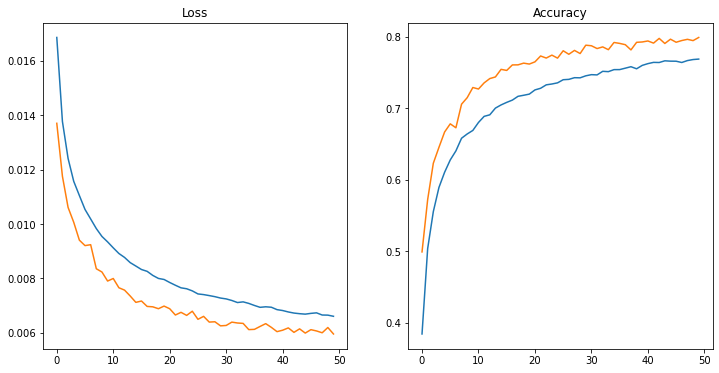

In [10]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validation loss")
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(running_corrects_history, label="training accuracy")
plt.plot(val_running_corrects_history, label="validation accuracy")

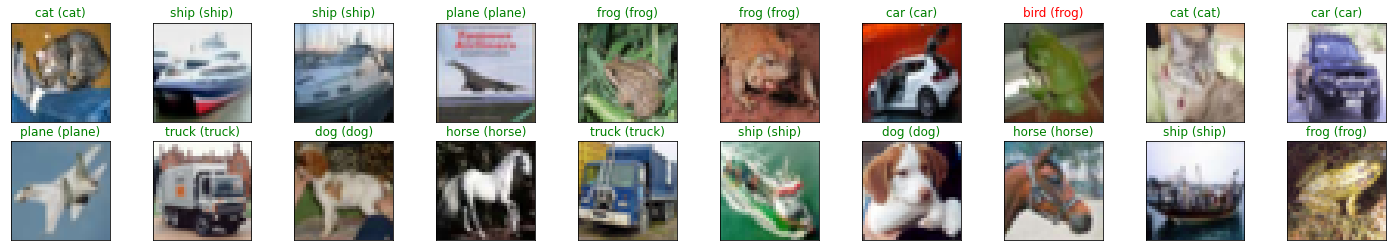

In [11]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
outputs = model.forward(images)
_, preds = torch.max(outputs,1)
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,10,idx + 1, xticks = [], yticks = [])
    plt.imshow(im_convert(images[idx]), cmap="gray")
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]== labels[idx] else "red"))

<Response [200]>


'bird'

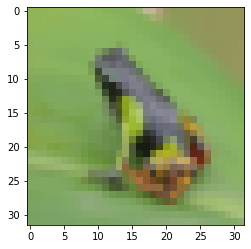

In [12]:
url = "https://upload.wikimedia.org/wikipedia/commons/c/c1/Variegated_golden_frog_%28Mantella_baroni%29_Ranomafana.jpg"
response = requests.get(url, stream=True)
print(response)
img = img_transform(response.raw)
plt.imshow(im_convert(img))
scores = model.forward(img.unsqueeze(0).to(device)) # unsqueeze to add a dim, to device to use gpu
_,  pred = torch.max(scores,1)
classes[pred]

<Response [200]>


'dog'

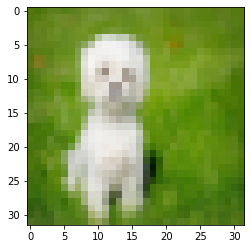

In [13]:
url = "https://specials-images.forbesimg.com/imageserve/5db4c7b464b49a0007e9dfac/960x0.jpg?fit=scale"
response = requests.get(url, stream=True)
print(response)
img = img_transform(response.raw)
plt.imshow(im_convert(img))
scores = model.forward(img.unsqueeze(0).to(device)) # unsqueeze to add a dim, to device to use gpu
_,  pred = torch.max(scores,1)
classes[pred]